# SIF Downscaling (using Duveiller model and a single time-step)

## Dependencies

In [6]:
using Pkg

Pkg.activate("/Net/Groups/BGI/work_3/OEMC/oemc_sif/bin")

using LinearAlgebra, Optim, Plots, Dates

using DimensionalData, YAXArrays, Zarr, Statistics, LineSearches, Revise

using Rasters: Center
using Rasters

  Activating project at `/Net/Groups/BGI/work_3/OEMC/oemc_sif/bin`


Functions from Duveiller and Cescatti 2016 (DOI:10.1016/j.rse.2016.04.027)

In [7]:

function focalWeightFilter(x)
    scale_fact = x
    mWm = scale_fact * 3
    xCent = repeat([-scale_fact, 0, scale_fact], inner=(x,mWm))'
    yCent = repeat([scale_fact, 0, -scale_fact], inner=(x, mWm))
    vPos = collect(1:scale_fact) .- (scale_fact / 2 + 0.5)
    xPos = repeat(vPos, outer=(x,mWm))'
    yPos = repeat(sort(vPos, rev=true), outer = (x,mWm))
    dista = -(sqrt.((xPos - xCent).^2 + (yPos - yCent).^2) ./ scale_fact)
    dista[isinf.(dista)] .= 0
    dista = dista .- (minimum(dista) - 0.000001)
    dista = dista .+ 0.1
    weights_matrix = fill(NaN, (mWm, mWm))
    
    for n in 1:scale_fact
        j = n - ((n - 1) ÷ scale_fact) * scale_fact
        k = scale_fact .* (0:2) .+ j
        
        for m in 1:scale_fact
            o = scale_fact .* (0:2) .+ m
            distaSum = sum(dista[o, k])
            weights_matrix[o, k] .= dista[o, k] ./ distaSum
        end
    end
    
    return weights_matrix
end

focalWeightFilter(3)

# Weighted focal filter (gaussian)

function gaussianWeightFilter(x)
    scale_fact = x
    mWm = scale_fact * 3
    yM = repeat(1:mWm, outer=(1,mWm))
    xM = repeat(1:mWm, outer=(1,mWm))'
    
    dista = exp.(-(((xM .- (scale_fact * 1.5)).^2) .+ ((yM .- (scale_fact * 1.5)).^2))./ (2 * scale_fact^2))

    weights_matrix = fill(NaN, mWm, mWm)

    for n in 1:scale_fact
        j = n - ((n - 1) ÷ scale_fact) * scale_fact
        k = scale_fact .* (0:2) .+ j
        for m in 1:scale_fact
            o = scale_fact .* (0:2) .+ m
            distaSum = sum(dista[o, k])
            weights_matrix[o, k] = dista[o, k] / distaSum
        end
    end

    return weights_matrix
end


# cost function

function costfun(b,VI,ET,LST,sif_ob)

    sif_pred = vegetation(VI, b[1], b[2]) .* water(ET, b[3], b[4]) .* temperature(LST, b[5], b[6])
    return sum((sif_pred .- sif_ob).^2)
    
end


# model components

function vegetation(VI, b1, b2)
    b2 .* (VI.^b1)
end

function water(ET, b3, b4)
    1 ./(1 .+exp.(b3.*(-ET.+b4)))
end

function temperature(LST, b5, b6)
    exp.(-0.5.*((LST.+b5)./b6).^2) 
end

function sif(VI, ET, LST, b)
    return vegetation(VI, b[1], b[2]) .* water(ET, b[3], b[4]) .* temperature(LST, b[5], b[6])
end

## Testing the functions ##

param_ini=[1, 2, 50.0, 0, -295, 10]

param_min=[0.5, 0.1, 0.0, -1, -310, 1]
param_max=[1.5, 5, 500.0, 1, -290, 50]


vi = [0.3,0.2,0.4, 0.8, 0.2]
et = [100.,200.,120., 40., 50.]
lst  = [28.,30.,25., 21., 28.]

sif_ob = sif(vi, et, lst, [1.35, 3, 120, -0.5, -291, 20])


inner_optimizer = LBFGS()

test = optimize(b -> costfun(b, vi, et, lst, sif_ob), param_min, param_max, param_ini, Fminbox(inner_optimizer))


Optim.minimizer(test)

6-element Vector{Float64}:
    1.0
    2.0
   50.0
    0.0
 -295.0
   10.0

## Preprocessing data

In [8]:

## Preprocessing

### Gridding TROPOMI data


#sif_gridding = `nohup julia ./gridL2_Dates.jl --latMin 29 --latMax 71 --lonMin -30 --lonMax 89 --dLat 0.05 --dLon 0.05  --dDays 8 --startDate 2020-01-01 --stopDate 2020-12-31  --Dict specifications.json  -o /Net/Groups/BGI/scratch/jgens/TROPOSIF/gridded/Europe_h17-h20_v2-v5/Europe_h17-h20_v2-v5_005_8daily_2020.nc &`

# run the gridding of TROPOMI product.

# run(sif_gridding)


# See preprocessing_jhoannes files for the migrations steps from Netcdf to Zarr

#=
## Data
#=
In the following example we will downscale TROPOSIF using Sentinel-3 satellite data and MODIS for a month (2018-07).
=#
### SIF low resolution


sif_cube = Cube(open_dataset("/Net/Groups/BGI/work_3/OEMC/oemc_sif/data/SIF_TROPOMI_gridded_10km_filtered_europe_2018-05-04_2020-12-26.zarr/"))


### selecting only SIF_743 and 2018-07


sif_cube_low = sif_cube[Ti = Between(DateTime("2018-07-01"),DateTime("2018-07-31")), Variable = At("SIF_743")]

heatmap(sif_cube_low.data[:,:,1])


### LST high resolution


lst_cube = Cube(open_dataset("/Net/Groups/BGI/work_3/OEMC/oemc_sif/data/LST_Sentinel3_gridded_1km_europe_2018-01-04_2020-12-29.zarr/"))

## selecting only 2018-07

lst_cube_high = lst_cube[Ti = Between(DateTime("2018-07-01"),DateTime("2018-07-31")), Variable = At("LST")]


### (WATER) MODIS NDWI


modis_cube = Cube(open_dataset("/Net/Groups/BGI/work_3/OEMC/oemc_sif/data/MC43A4_gridded_1km_europe_2018-05-01_2020-12-31_YAXA.zarr/"))


## selecting only 2018-07


modis_cube_high = modis_cube[Ti = Between(DateTime("2018-07-01"),DateTime("2018-07-31"))]

# Computing NDWI

function ndwi(out, b4,b2)
    if !isnan.(b4) && !isnan.(b2) && !isinf.(b4) && !isinf.(b2)
        out .= (b4[:]-b2[:])/(b4[:] + b2[:])

    else
        out .= NaN32
    end
end

indims = (InDims(), InDims())

outdims = OutDims(Dim{:Variable}(["NDWI"]))

ndwi_cube_high = mapCube(ndwi, (modis_cube_high[Variable = At("4")], modis_cube_high[Variable = At("2")]), indims = indims, outdims=outdims)

# quick check
heatmap(ndwi_cube_high.data[:,:,3,1])


### (VEGETATION) Sentinel-3 OTCI (Terrestrial Chlorophyll Index)


sentinel_3_cube = Cube(open_dataset("/Net/Groups/BGI/work_3/OEMC/oemc_sif/data/OLCI_Sentinel3_gridded_1km_europe_2018-01-04_2020-12-29.zarr/"))

sentinel_3_cube.Variable

### selecting only OGVI and 2018-07

ogvi_cube_high = sentinel_3_cube[Variable = At("OGVI"), Ti = Between(DateTime("2018-07-01"),DateTime("2018-07-31"))]


#=
Collapsing time dimension. As data for each one of the product has a different length, and interpolation with 4 points is risky let's estimate the mean for the month of july
=#

lookup(sif_cube_low, :Ti)
lookup(lst_cube_high, :Ti)
lookup(ndwi_cube_high, :Ti)
lookup(otci_cube_high, :Ti)

function temporal_mean(out, in)
    if !all(isnan, in)
        out .= mean(filter(!isnan, in))
    else
        out .= NaN32 
    end
    
end

indims = InDims(:Ti)
outdims = OutDims()

sif_cube_low_july = mapCube(temporal_mean, sif_cube_low, indims = indims, outdims = outdims)



lst_cube_high_july = mapCube(temporal_mean, lst_cube_high, indims = indims, outdims = outdims)

ndwi_cube_high_july = mapCube(temporal_mean, ndwi_cube_high, indims = indims, outdims = outdims)

ogvi_cube_high_july = mapCube(temporal_mean, ogvi_cube_high, indims = indims, outdims = outdims)


### saving data data



savecube(sif_cube_low_july, "/Net/Groups/BGI/work_3/OEMC/oemc_sif/data/sif_cube_low_july.zarr"; overwrite = true)
savecube(lst_cube_high_july, "/Net/Groups/BGI/work_3/OEMC/oemc_sif/data/lst_cube_high_july.zarr"; overwrite = true)
savecube(ogvi_cube_high_july, "/Net/Groups/BGI/work_3/OEMC/oemc_sif/data/ogvi_cube_high_july.zarr"; overwrite = true)
savecube(ndwi_cube_high_july, "/Net/Groups/BGI/work_3/OEMC/oemc_sif/data/ndwi_cube_high_july.zarr"; overwrite = true)


=#


## Data (high resolution)

In [9]:
lst_cube_high_july = Cube(open_dataset("/Net/Groups/BGI/work_3/OEMC/oemc_sif/data/lst_cube_high_july.zarr"))

ogvi_cube_high_july = Cube(open_dataset("/Net/Groups/BGI/work_3/OEMC/oemc_sif/data/ogvi_cube_high_july.zarr"))

ndwi_cube_high_july = Cube(open_dataset("/Net/Groups/BGI/work_3/OEMC/oemc_sif/data/ndwi_cube_high_july.zarr"))



4800×4800 YAXArray{Union{Missing, Float32},2} with dimensions: 
  X Sampled{Int64} 1:1:4800 ForwardOrdered Regular Points,
  Y Sampled{Int64} 1:1:4800 ForwardOrdered Regular Points
name: NDWI
Total size: 87.89 MB


## Data (low resolution)

In [10]:
sif_cube_low_july = Cube(open_dataset("/Net/Groups/BGI/work_3/OEMC/oemc_sif/data/sif_cube_low_july.zarr"))

lst_cube_low = Cube(open_dataset("/Net/Groups/BGI/work_3/OEMC/oemc_sif/data/low_res/lst_cube_low_july.zarr"))

ndwi_cube_low = Cube(open_dataset("/Net/Groups/BGI/work_3/OEMC/oemc_sif/data/low_res/ndwi_cube_low_july.zarr"))

ogvi_cube_low = Cube(open_dataset("/Net/Groups/BGI/work_3/OEMC/oemc_sif/data/low_res/ogvi_cube_low_july.zarr"))

480×480 YAXArray{Union{Missing, Float32},2} with dimensions: 
  X Sampled{Int64} 1:1:480 ForwardOrdered Regular Points,
  Y Sampled{Int64} 1:1:480 ForwardOrdered Regular Points
name: layer
Total size: 900.0 KB


## Parameter optimization using a moving window

In [11]:
function param_optim(out, sif, vegetation, water, temperature; param_ini = [1.,2.,50.,0.,-295.,10.], param_min = [0.5,0.1,0,-1.,-310.,1.], param_max = [1.5,5.,500.,1.,-290.,50.], min_obs = 21, inner_optimizer = LBFGS())
    
    
    # checking that we have at least min_obs data points for each variable in the local window
    
    if !all(isnan, sif) && !all(isnan, vegetation) && !all(isnan, water) && !all(isnan, temperature)
        if length(filter(!isnan, vec(sif))) >= min_obs && length(filter(!isnan, vec(vegetation))) >= min_obs && length(filter(!isnan, vec(water))) >= min_obs && length(filter(!isnan, vec(temperature))) >= min_obs
            
            if length(filter(!isnan, vec(sif))) == length(filter(!isnan, vec(vegetation))) && length(filter(!isnan, vec(sif)))== length(filter(!isnan, vec(water))) && length(filter(!isnan, vec(sif))) == length(filter(!isnan, vec(temperature)))
                
                vi = filter(!isnan, vec(vegetation))
                agua = filter(!isnan, vec(water))
                lst = filter(!isnan, vec(temperature))
                sif_ob = filter(!isnan, vec(sif))
                
                test = optimize(b -> costfun(b, vi, agua, lst, sif_ob), param_min, param_max, param_ini, Fminbox(inner_optimizer))
                
                out .= Optim.minimizer(test) 
                
                
            else
                out .= NaN32
                
            end
        else
            out .= NaN32
        end 
    else
        out .= NaN32
    end
    
end

param_optim (generic function with 1 method)

In [12]:
window_edge = 25

if isodd(window_edge) 
    pre_step = after_step = floor(window_edge / 2) 
else 
    pre_step = after_step = floor(window_edge / 2) - 1
end

indims = (InDims(MovingWindow(:X, pre_step, after_step), MovingWindow(:Y, pre_step, after_step), window_oob_value = NaN), InDims(MovingWindow(:X, pre_step, after_step), MovingWindow(:Y, pre_step, after_step), window_oob_value = NaN),InDims(MovingWindow(:X, pre_step, after_step), MovingWindow(:Y, pre_step, after_step), window_oob_value = NaN),InDims(MovingWindow(:X, pre_step, after_step), MovingWindow(:Y, pre_step, after_step), window_oob_value = NaN))

outdims = OutDims(Dim{:parameters_optim}(["b1", "b2", "b3", "b4", "b5", "b6"]))

OutDims((YAXArrays.ByValue(Dim{:parameters_optim, Vector{String}}(["b1", "b2", "b3", "b4", "b5", "b6"])),), :auto, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}(), false, Array, :input, 1)

In [13]:
parameters_cube = mapCube(param_optim, (sif_cube_low_july[X=1:200, Y = 1:200], ogvi_cube_low[X=1:200, Y = 1:200], ndwi_cube_low[X=1:200, Y = 1:200], lst_cube_low[X=1:200, Y = 1:200]), indims = indims, outdims = outdims, inner_optimizer = LBFGS(), param_ini = [1.,2.,50.,0.,-295.,10.], param_min = [0.,0.,0.,-10.,-310.,-10.], param_max = [4.,20.,500.,10.,290.,100.]) 

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Net/Groups/BGI/people/dpabon/bin/julia_packages/packages/LineSearches/G1LRk/src/hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Net/Groups/BGI/people/dpabon/bin/julia_packages/packages/LineSearches/G1LRk/src/hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Net/Groups/BGI/people/dpabon/bin/julia_packages/packages/LineSearches/G1LRk/src/hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Net/Groups/BGI/people/dpabon/bin/julia_packages/packages/LineSearches/G1LRk/src/hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches /Net/Groups/BGI/people/dpabon/bin/julia_packages/packages/LineSearches/G1LRk/src/hagerzhang.jl:148
┌ Warning: Failed to achieve finite new evaluation point, us

6×200×200 YAXArray{Union{Missing, Float32},3} with dimensions: 
  Dim{:parameters_optim} Categorical{String} String[b1, b2, …, b5, b6] ForwardOrdered,
  X Sampled{Int64} 1:1:200 ForwardOrdered Regular Points,
  Y Sampled{Int64} 1:1:200 ForwardOrdered Regular Points
Total size: 937.5 KB


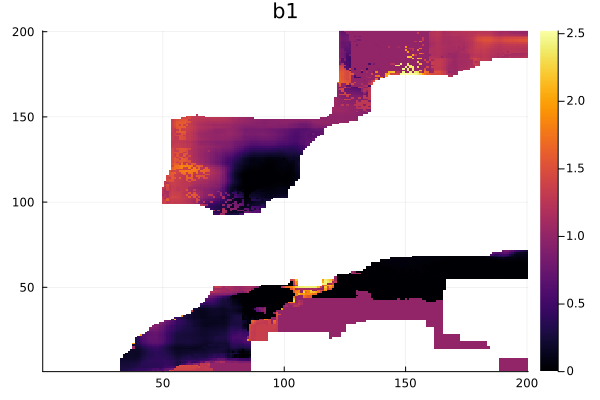

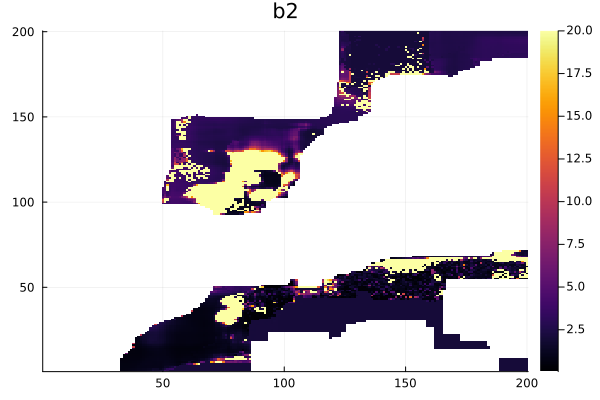

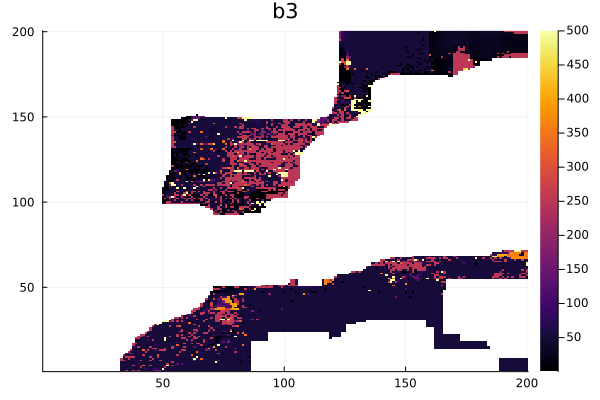

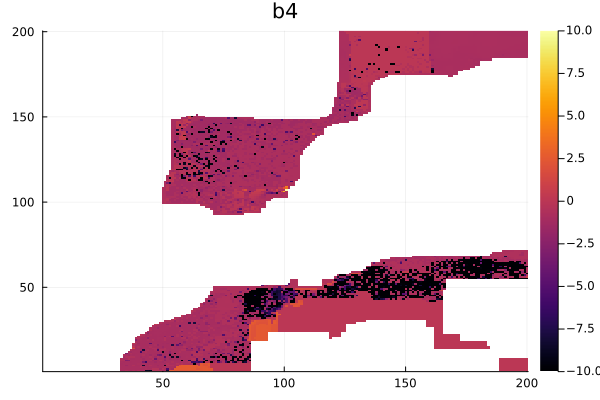

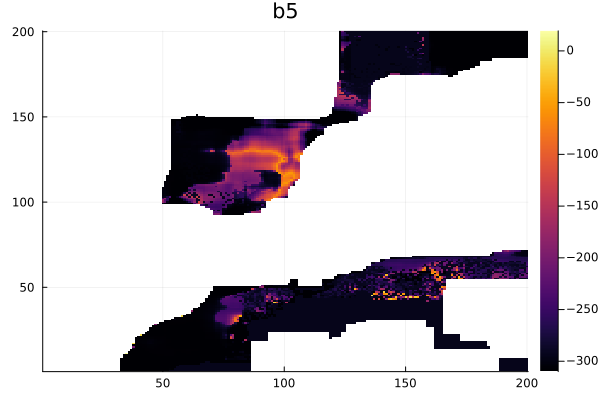

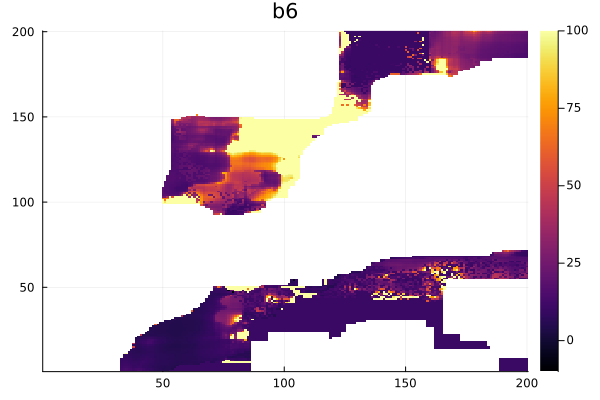

In [20]:
for i in 1:6
   display(heatmap(parameters_cube.data[i,:,:], title = "b"*string(i)))
end

In [29]:
function disaggregate_space(out,incube; scale_factor, axes) 
    test = Raster(replace(incube, NaN32 => missing), axes) 
    test_out = disaggregate(Center(), test, (scale_factor, scale_factor)) 
    out .= replace(test_out.data, missing => NaN32)

end

indims = InDims(:X,:Y)

outdims = OutDims(Dim{:X}(1:2000), Dim{:Y}(1:2000))


OutDims((YAXArrays.ByValue(Dim{:X, UnitRange{Int64}}(1:2000)), YAXArrays.ByValue(Dim{:Y, UnitRange{Int64}}(1:2000))), :auto, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}(), false, Array, :input, 1)

In [30]:
axes = parameters_cube.axes[2:3]

X Sampled{Int64} 1:1:200 ForwardOrdered Regular Points,
Y Sampled{Int64} 1:1:200 ForwardOrdered Regular Points

In [31]:
scale_factor = 10

10

In [32]:
parameters_cube_high = mapCube(disaggregate_space, parameters_cube, indims = indims, outdims = outdims; scale_factor=scale_factor, axes=axes)

2000×2000×6 YAXArray{Union{Missing, Float32},3} with dimensions: 
  Dim{:X} Sampled{Int64} 1:2000 ForwardOrdered Regular Points,
  Dim{:Y} Sampled{Int64} 1:2000 ForwardOrdered Regular Points,
  Dim{:parameters_optim} Categorical{String} String[b1, b2, …, b5, b6] ForwardOrdered
Total size: 91.55 MB


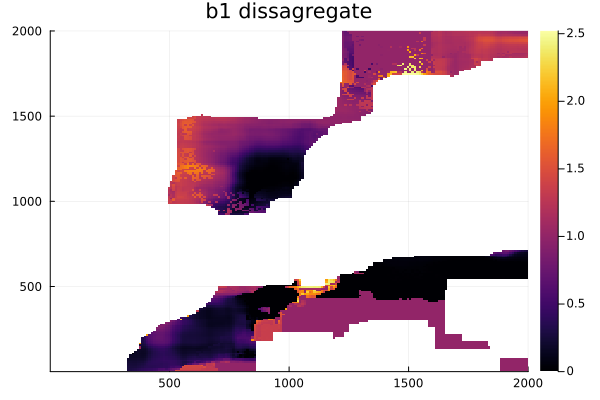

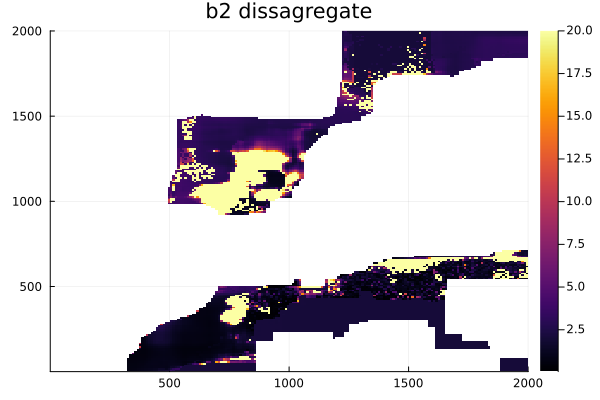

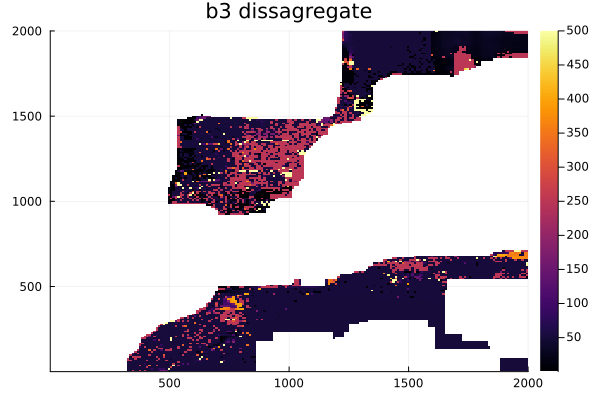

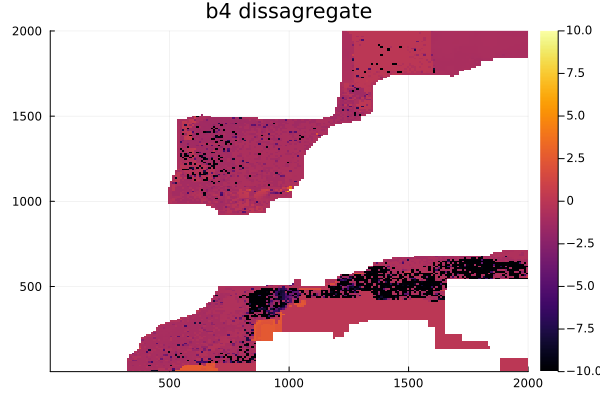

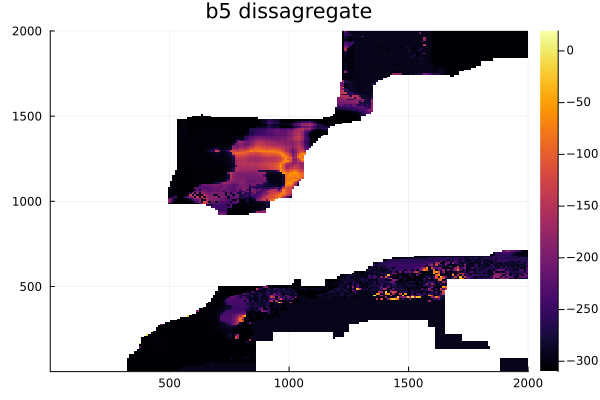

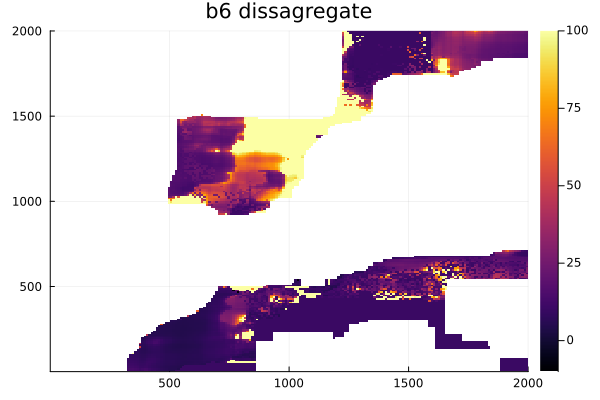

In [34]:
for i in 1:6
   display(heatmap(parameters_cube_high.data[:,:,i], title = "b"*string(i)*" dissagregate"))
end

## Estimating sif at high resolution

In [35]:
# function to estimate sif using high resolution data

function sif_downscaling(out, vegetation, water, temperature, parameters) 
    if !all(isnan, vegetation) && !all(isnan, water) && !all(isnan, temperature) && !all(isnan, parameters)
        
        if length(filter(!isnan, vec(vegetation)))== length(filter(!isnan, vec(water))) && length(filter(!isnan, vec(vegetation))) == length(filter(!isnan, vec(temperature)))
            
            b_optim = [mean(parameters[:,:,1]),
            mean(parameters[:,:,2]),
            mean(parameters[:,:,3]),
            mean(parameters[:,:,4]),
            mean(parameters[:,:,5]),
            mean(parameters[:,:,6])]
            length(b_optim)
            
            out .= sif(mean(filter(!isnan, vegetation)), mean(filter(!isnan, water)), mean(filter(!isnan, temperature)), b_optim)
        else
            out .= NaN32
        end 
    else
        out .= NaN32
    end
end


sif_downscaling (generic function with 1 method)

using another moving window of 3x3 to Downscale SIF

In [36]:
window_edge = 3

if isodd(window_edge) 
    pre_step = after_step = floor(window_edge / 2) 
else 
    pre_step = after_step = floor(window_edge / 2) - 1 
end

indims = (InDims(MovingWindow(:X, pre_step, after_step), MovingWindow(:Y, pre_step, after_step), window_oob_value = NaN), InDims(MovingWindow(:X, pre_step, after_step), MovingWindow(:Y, pre_step, after_step), window_oob_value = NaN),InDims(MovingWindow(:X, pre_step, after_step), MovingWindow(:Y, pre_step, after_step), window_oob_value = NaN),InDims(MovingWindow(:X, pre_step, after_step), MovingWindow(:Y, pre_step, after_step), window_oob_value = NaN, :parameters_optim))

outdims = OutDims(Dim{:SIF}(["sif_downscaled"]))

OutDims((YAXArrays.ByValue(Dim{:SIF, Vector{String}}(["sif_downscaled"])),), :auto, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}(), false, Array, :input, 1)

In [46]:
ogvi_cube_high_july = ogvi_cube_high_july[X=1:2000,Y=1:2000]
axlist = (
    Dim{:X}(1:2000),
    Dim{:Y}(1:2000))

ogvi_cube_high_july = YAXArray(axlist, ogvi_cube_high_july.data[:,:])

2000×2000 YAXArray{Union{Missing, Float32},2} with dimensions: 
  Dim{:X} Sampled{Int64} 1:2000 ForwardOrdered Regular Points,
  Dim{:Y} Sampled{Int64} 1:2000 ForwardOrdered Regular Points
Total size: 15.26 MB


In [44]:
ndwi_cube_high_july = ndwi_cube_high_july[X=1:2000, Y=1:2000]
axlist = (
    Dim{:X}(1:2000),
    Dim{:Y}(1:2000))

ndwi_cube_high_july = YAXArray(axlist, ndwi_cube_high_july.data[:,:])

2000×2000 YAXArray{Union{Missing, Float32},2} with dimensions: 
  Dim{:X} Sampled{Int64} 1:2000 ForwardOrdered Regular Points,
  Dim{:Y} Sampled{Int64} 1:2000 ForwardOrdered Regular Points
Total size: 15.26 MB


In [45]:
lst_cube_high_july = lst_cube_high_july[X=1:2000, Y = 1:2000]

axlist = (
    Dim{:X}(1:2000),
    Dim{:Y}(1:2000))

lst_cube_high_july = YAXArray(axlist, lst_cube_high_july.data[:,:])

2000×2000 YAXArray{Union{Missing, Float32},2} with dimensions: 
  Dim{:X} Sampled{Int64} 1:2000 ForwardOrdered Regular Points,
  Dim{:Y} Sampled{Int64} 1:2000 ForwardOrdered Regular Points
Total size: 15.26 MB


In [43]:
parameters_cube_high

2000×2000×6 YAXArray{Union{Missing, Float32},3} with dimensions: 
  Dim{:X} Sampled{Int64} 1:2000 ForwardOrdered Regular Points,
  Dim{:Y} Sampled{Int64} 1:2000 ForwardOrdered Regular Points,
  Dim{:parameters_optim} Categorical{String} String[b1, b2, …, b5, b6] ForwardOrdered
Total size: 91.55 MB


In [47]:
sif_cube_high = mapCube(sif_downscaling, (ogvi_cube_high_july, ndwi_cube_high_july, lst_cube_high_july, parameters_cube_high), indims = indims, outdims = outdims)

1×2000×2000 YAXArray{Union{Missing, Float32},3} with dimensions: 
  Dim{:SIF} Categorical{String} String["sif_downscaled"] ForwardOrdered,
  Dim{:X} Sampled{Int64} 1:2000 ForwardOrdered Regular Points,
  Dim{:Y} Sampled{Int64} 1:2000 ForwardOrdered Regular Points
Total size: 15.26 MB


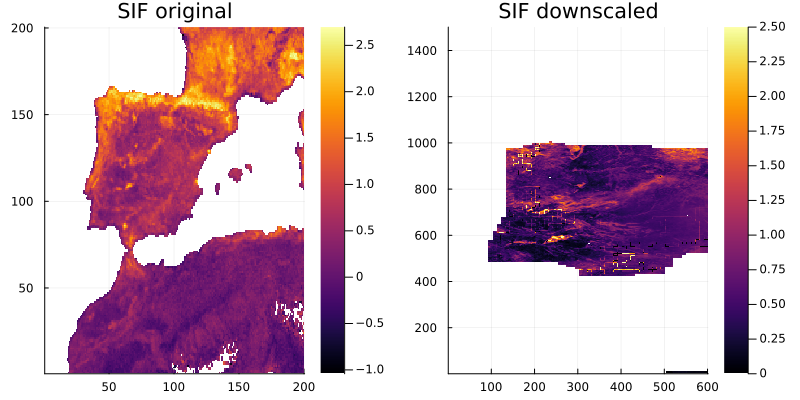

In [59]:
p1 = heatmap(sif_cube_low_july.data[1:200,1:200], title = "SIF original")
p2 = heatmap(sif_cube_high.data[1, 500:2000,400:1000], clim = (0,2.5), title = "SIF downscaled")

plot(p1,p2)
plot!(size=(800,400))

In [52]:
?plot


search: plot plot! plotly plot3d Plots plot3d! plotlyjs plotattr plotarea



The main plot command. Use `plot` to create a new plot object, and `plot!` to add to an existing one:

```
    plot(args...; kw...)                  # creates a new plot window, and sets it to be the current
    plot!(args...; kw...)                 # adds to the `current`
    plot!(plotobj, args...; kw...)        # adds to the plot `plotobj`
```

There are lots of ways to pass in data, and lots of keyword arguments... just try it and it will likely work as expected. When you pass in matrices, it splits by columns. To see the list of available attributes, use the `plotattr(attr)` function, where `attr` is the symbol `:Series`, `:Subplot`, `:Plot`, or `:Axis`. Pass any attribute to `plotattr` as a String to look up its docstring, e.g., `plotattr("seriestype")`.

---

Extract a subplot from an existing plot.

# Examples

```julia-repl
julia> p1, p2 = plot(1:2), plot(10:20)
julia> pl = plot(p1, p2)  # plot containing 2 subplots

julia> plot(pl.subplots[1])  # extract 1st subplot as a standalone plot
julia> plot(pl.subplots[2])  # extract 2nd subplot as a standalone plot
```

---

REPL.Message("Extended help is available with `??`", (color = :cyan, bold = true))
